<a href="https://colab.research.google.com/github/AttiBae/BasicML/blob/main/Chapter5_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable as Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import random

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
MNIST_transform = transforms.Compose([transforms.Resize((28,28)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data/MNIST/', 
                           train=True,
                           download = True, 
                           transform=MNIST_transform)

testset = datasets.MNIST(root='./data/MNIST/', 
                           train=False, 
                           download = True, 
                           transform=MNIST_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = DataLoader(trainset, batch_size = 32, shuffle = True)
test_loader = DataLoader(testset, batch_size = 32, shuffle = True)

dataloaders = [train_loader, test_loader]

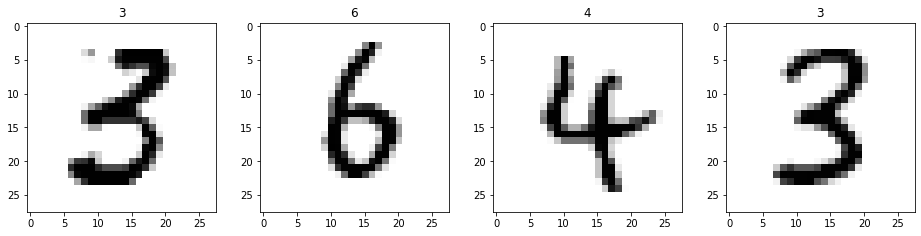

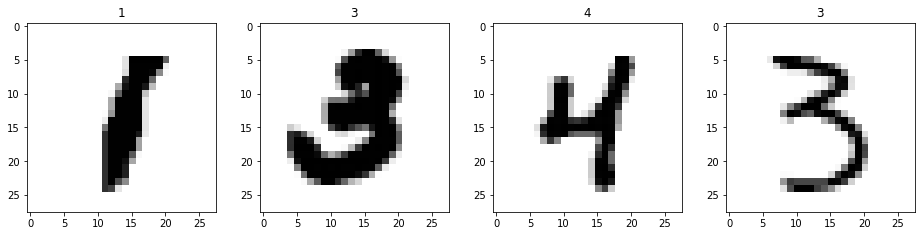

In [ ]:
image, label = next(iter(train_loader))

plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i].squeeze(0), cmap='gray_r')
    plt.title(label[i].numpy())

image, label = next(iter(test_loader))

plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i].squeeze(0), cmap='gray_r')
    plt.title(label[i].numpy())    

In [ ]:
class gen(nn.Module):
  def __init__(self):
    super(gen, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(100, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 28 * 28),
        nn.Tanh(),
    )

  def forward(self, x):
    output = self.main(x)
    output = output.view(x.size(0), 1, 28, 28)
    return output

class dis(nn.Module):
  def __init__(self):
    super(dis, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(28 * 28, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    )
        
  def forward(self, x):
    x = x.view(x.size(0), 28 * 28)
    output = self.main(x)
    return output

In [ ]:
criterion = nn.BCELoss()
learning_rate = 0.0001
num_epochs = 50
batch_size = 32

netG = gen().to(device)
netD = dis().to(device)

optimizer_gen = torch.optim.Adam(netG.parameters(), lr=learning_rate)
optimizer_dis = torch.optim.Adam(netD.parameters(), lr=learning_rate)

In [ ]:
random_plot_data = torch.randn((batch_size, 100)).to(device)

start_time = time.time()
for epoch in range(num_epochs):
  print('-----------------------------------')
  print('{} Epoch'.format(epoch))
  for n, (data, target) in enumerate(train_loader):
    data, label = data.to(device), torch.ones((batch_size, 1)).to(device)
    random_data = torch.randn((batch_size, 100)).to(device)
    gen_data = netG(random_data)
    gen_label = torch.zeros((batch_size, 1)).to(device)
    all = torch.cat((data, gen_data))
    all_label = torch.cat((label, gen_label))


    netD.zero_grad()
    output_dis = netD(all)
    loss_dis = criterion(output_dis, all_label)
    loss_dis.backward()
    optimizer_dis.step()

    random_data = torch.randn((batch_size, 100)).to(device)
    netG.zero_grad()
    gen_data = netG(random_data)
    output_dis = netD(gen_data)
    loss_gen = criterion(output_dis, label)
    loss_gen.backward()
    optimizer_gen.step()
    
    # random_data = torch.randn((batch_size, 100)).to(device)
    # data, label = data.to(device), torch.ones((batch_size, 1)).to(device)
    # gen_data, gen_label = netG(random_data), torch.zeros((batch_size, 1)).to(device)

    # output_dis_real = netD(data)
    # output_dis_fake = netD(gen_data)
    # loss_dis_real = criterion(output_dis_real, label)
    # loss_dis_fake = criterion(output_dis_fake, gen_label)
    # loss_dis = loss_dis_real + loss_dis_fake

    # netD.zero_grad()
    # loss_dis.backward()
    # optimizer_dis.step()


    # random_data = torch.randn((batch_size, 100)).to(device)
    # gen_data = netG(random_data)
    # output_dis = netD(gen_data)

    # loss_gen = criterion(output_dis, label)
    # netG.zero_grad()
    # loss_gen.backward()
    # optimizer_gen.step()

    if n == batch_size - 1:
        print(f"Dis Loss: {loss_dis}")
        print(f"Gen Loss: {loss_gen}\n")
        
        gen_data_plot = netG(random_plot_data).cpu().detach()
        fig = plt.figure(figsize = (10,7))
        fig.suptitle(f"Generated Images After {epoch} Epochs", fontsize=16)
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(gen_data_plot[i].reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([])
        plt.show()
        
elapsed_time = time.time() - start_time
print('\nElapsed time : {}s'.format(elapsed_time))


torch.save(netG.state_dict(), '/content/drive/MyDrive/BasicML/Chapter5/G_mnist_model.pt')
torch.save(netD.state_dict(), '/content/drive/MyDrive/BasicML/Chapter5/D_mnist_model.pt')

-----------------------------------
0 Epoch
Dis Loss: 0.5315752625465393
Gen Loss: 0.5527387261390686

-----------------------------------
1 Epoch
Dis Loss: 0.04292238503694534
Gen Loss: 5.532548904418945

-----------------------------------
2 Epoch
Dis Loss: 0.002795787528157234
Gen Loss: 11.721648216247559

-----------------------------------
3 Epoch
Dis Loss: 0.07566578686237335
Gen Loss: 4.486104965209961

-----------------------------------
4 Epoch
Dis Loss: 0.1560661792755127
Gen Loss: 5.820415019989014

-----------------------------------
5 Epoch
Dis Loss: 0.03232763707637787
Gen Loss: 5.105410575866699

-----------------------------------
6 Epoch
Dis Loss: 0.07028433680534363
Gen Loss: 3.8995485305786133

-----------------------------------
7 Epoch
Dis Loss: 0.29864591360092163
Gen Loss: 2.5415632724761963

-----------------------------------
8 Epoch
Dis Loss: 0.24562683701515198
Gen Loss: 2.412104368209839

-----------------------------------
9 Epoch
Dis Loss: 0.38865298032760

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1,16, kernel_size = 5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 32)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model_valid = ConvNet()
model_valid.load_state_dict(torch.load('/content/drive/MyDrive/BasicML/Chapter4/mnist_model.pt'))
model_valid.eval()

if torch.cuda.is_available():
  device = torch.device('cuda')
  model_valid = model_valid.to(device)
  is_cuda = 1
else: is_cuda = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


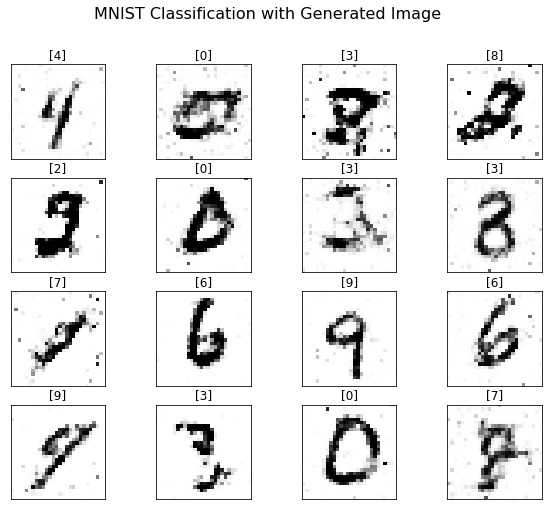

In [ ]:
gen_data_plot = netG(random_plot_data).cpu().detach()

fig = plt.figure(figsize = (10,8))
fig.suptitle(f"MNIST Classification with Generated Image", fontsize=16)
for i in range(16):
    gen_data_plot = gen_data_plot.to(device)
    outputs = model_valid(gen_data_plot)  ## Put images to network
    pred_1 = outputs.data.max(dim=1, keepdim=True)[1]  ## prediction
    ax = plt.subplot(4, 4, i + 1)
    plt.title(pred_1[i].cpu().numpy())
    plt.imshow(gen_data_plot[i].cpu().detach().reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
plt.show()